In [1]:
import torch 
import torch.nn as nn 
import torch.optim as optim 

from PIL import Image, ImageFile 
ImageFile.LOAD_TRUNCATED_IMAGES = True

import os 
import numpy as np 
import pandas as pd 
  
import matplotlib.pyplot as plt 
import matplotlib.patches as patches 
  
from tqdm import tqdm

from src.classifier.utils.spike_to_tensor import gen_bin_event_tensor

In [2]:
# Defining a function to calculate Intersection over Union (IoU)
def iou(box1, box2, is_pred=True):
    if is_pred:
        # IoU score for prediction and label
        # box1 (prediction) and box2 (label) are both in [x, y, width, height] format

        # Box coordinates of prediction
        b1_x1 = box1[..., 0:1] - box1[..., 2:3] / 2
        b1_y1 = box1[..., 1:2] - box1[..., 3:4] / 2
        b1_x2 = box1[..., 0:1] + box1[..., 2:3] / 2
        b1_y2 = box1[..., 1:2] + box1[..., 3:4] / 2

        # Box coordinates of ground truth
        b2_x1 = box2[..., 0:1] - box2[..., 2:3] / 2
        b2_y1 = box2[..., 1:2] - box2[..., 3:4] / 2
        b2_x2 = box2[..., 0:1] + box2[..., 2:3] / 2
        b2_y2 = box2[..., 1:2] + box2[..., 3:4] / 2

        # Get the coordinates of the intersection rectangle
        x1 = torch.max(b1_x1, b2_x1)
        y1 = torch.max(b1_y1, b2_y1)
        x2 = torch.min(b1_x2, b2_x2)
        y2 = torch.min(b1_y2, b2_y2)
        # Make sure the intersection is at least 0
        intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

        # Calculate the union area
        box1_area = abs((b1_x2 - b1_x1) * (b1_y2 - b1_y1))
        box2_area = abs((b2_x2 - b2_x1) * (b2_y2 - b2_y1))
        union = box1_area + box2_area - intersection

        # Calculate the IoU score
        epsilon = 1e-6
        iou_score = intersection / (union + epsilon)

        # Return IoU score
        return iou_score

    else:
        # IoU score based on width and height of bounding boxes

        # Calculate intersection area
        intersection_area = torch.min(box1[..., 0], box2[..., 0]) * torch.min(
            box1[..., 1], box2[..., 1]
        )

        # Calculate union area
        box1_area = box1[..., 0] * box1[..., 1]
        box2_area = box2[..., 0] * box2[..., 1]
        union_area = box1_area + box2_area - intersection_area

        # Calculate IoU score
        iou_score = intersection_area / union_area

        # Return IoU score
        return iou_score

In [3]:
# Function to plot images with bounding boxes and class labels 
def plot_image(image, boxes): 
    # Getting the color map from matplotlib 
    colour_map = plt.get_cmap("tab20b") 
    # Getting 2 different colors from the color map for 20 different classes 
    colors = [colour_map(i) for i in np.linspace(0, 1, NUM_CLASSES)] 
  
    # Reading the image with OpenCV 
    img = np.array(image).sum(axis=-1) # sum over time axis
    # Getting the height and width of the "image" (the tensor with the "frames")
    h, w = img.shape
  
    # Create figure and axes 
    fig, ax = plt.subplots(1) 
  
    # Add image to plot 
    ax.imshow(img) 
  
    # Plotting the bounding boxes and labels over the image 
    for box in boxes: 
        # Get the class from the box 
        class_pred = box[0] 
        # Get the center x and y coordinates 
        box = box[2:] 
        # Get the upper left corner coordinates 
        upper_left_x = box[0] - box[2] / 2
        upper_left_y = box[1] - box[3] / 2
  
        # Create a Rectangle patch with the bounding box 
        rect = patches.Rectangle( 
            (upper_left_x * w, upper_left_y * h), 
            box[2] * w, 
            box[3] * h, 
            linewidth=2, 
            edgecolor=colors[int(class_pred)], 
            facecolor="none", 
        ) 
          
        # Add the patch to the Axes 
        ax.add_patch(rect) 
          
        # Add class name to the patch 
        plt.text( 
            upper_left_x * w, 
            upper_left_y * h,
            s=CLASS_LABELS[int(class_pred)], 
            color="white",
            verticalalignment="top", 
            bbox={"color": colors[int(class_pred)], "pad": 0}, 
        )
  
    # Display the plot 
    plt.show()

In [4]:
# Non-maximum suppression function to remove overlapping bounding boxes 
def nms(bboxes, iou_threshold, threshold): 
    # Filter out bounding boxes with confidence below the threshold. 
    bboxes = [box for box in bboxes if box[1] > threshold] 
  
    # Sort the bounding boxes by confidence in descending order. 
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True) 
  
    # Initialize the list of bounding boxes after non-maximum suppression. 
    bboxes_nms = [] 
  
    while bboxes: 
        # Get the first bounding box. 
        first_box = bboxes.pop(0) 
  
        # Iterate over the remaining bounding boxes. 
        for box in bboxes: 
        # If the bounding boxes do not overlap or if the first bounding box has 
        # a higher confidence, then add the second bounding box to the list of 
        # bounding boxes after non-maximum suppression. 
            if box[0] != first_box[0] or iou( 
                torch.tensor(first_box[2:]), 
                torch.tensor(box[2:]), 
            ) < iou_threshold: 
                # Check if box is not in bboxes_nms 
                if box not in bboxes_nms: 
                    # Add box to bboxes_nms 
                    bboxes_nms.append(box) 
  
    # Return bounding boxes after non-maximum suppression. 
    return bboxes_nms

In [5]:
# Function to convert cells to bounding boxes 
def convert_cells_to_bboxes(predictions, anchors, s, is_predictions=True): 
    # Batch size used on predictions 
    batch_size = predictions.shape[0] 
    # Number of anchors 
    num_anchors = len(anchors)
    # List of all the predictions 
    box_predictions = predictions[..., 1:5] 
  
    # If the input is predictions then we will pass the x and y coordinate 
    # through sigmoid function and width and height to exponent function and 
    # calculate the score and best class. 
    if is_predictions: 
        anchors = anchors.reshape(1, len(anchors), 1, 1, 2) 
        box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2]) 
        box_predictions[..., 2:] = torch.exp( 
            box_predictions[..., 2:]) * anchors 
        scores = torch.sigmoid(predictions[..., 0:1]) 
        best_class = torch.argmax(predictions[..., 5:], dim=-1).unsqueeze(-1) 
      
    # Else we will just calculate scores and best class. 
    else: 
        scores = predictions[..., 0:1] 
        best_class = predictions[..., 5:6]
  
    # Calculate cell indices 
    cell_indices = ( 
        torch.arange(s) 
        .repeat(predictions.shape[0], N_ANCHORS_PER_GRID, s, 1) 
        .unsqueeze(-1) 
        .to(predictions.device) 
    ) 
  
    # Calculate x, y, width and height with proper scaling 
    x = 1 / s * (box_predictions[..., 0:1] + cell_indices) 
    y = 1 / s * (box_predictions[..., 1:2] +
                 cell_indices.permute(0, 1, 3, 2, 4)) 
    width_height = 1 / s * box_predictions[..., 2:4] 
  
    # Concatinating the values and reshaping them in 
    # (BATCH_SIZE, num_anchors * S * S, 6) shape 
    converted_bboxes = torch.cat( 
        (best_class, scores, x, y, width_height), dim=-1
    ).reshape(batch_size, num_anchors * s * s, 6) 
  
    # Returning the reshaped and converted bounding box list 
    return converted_bboxes.tolist()

In [6]:
# Function to save checkpoint 
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth.tar"): 
    print("==> Saving checkpoint") 
    checkpoint = { 
        "state_dict": model.state_dict(), 
        "optimizer": optimizer.state_dict(), 
    } 
    torch.save(checkpoint, filename)

In [7]:
# Function to load checkpoint 
def load_checkpoint(checkpoint_file, model, optimizer, lr): 
    print("==> Loading checkpoint") 
    checkpoint = torch.load(checkpoint_file, map_location=device) 
    model.load_state_dict(checkpoint["state_dict"]) 
    optimizer.load_state_dict(checkpoint["optimizer"]) 
  
    for param_group in optimizer.param_groups: 
        param_group["lr"] = lr 

In [8]:
# Device
device = "cuda" if torch.cuda.is_available() else "cpu"

# Load and save model variable
load_model = False
save_model = True

# model checkpoint file name
checkpoint_file = "checkpoint.pth.tar"

# Anchor boxes for each feature map scaled between 0 and 1
# 3 feature maps at 3 different scales based on YOLOv3 paper
'''
ANCHORS = [
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)],
]#'''
# first try with just 2 anchors on one scale
ANCHORS = [
    [(0.9, 0.7), (0.35, 0.7)]
]

#GRID_RES = [32, 16, 8]
GRID_RES = [4]

N_GRID_RES = len(GRID_RES)
assert N_GRID_RES == len(ANCHORS)

N_ANCHORS_PER_GRID = len(ANCHORS[0])

# Batch size for training
batch_size = 32

# Learning rate for training
learning_rate = 1e-5

# Number of epochs for training
epochs = 20

# Image size
IMAGE_SIZE = (304, 240)

# Grid cell sizes
SX = [IMAGE_SIZE[0] // gr for gr in GRID_RES]
SY = [IMAGE_SIZE[1] // gr for gr in GRID_RES]

# Class labels
CLASS_LABELS = ["car", "pedestrian"]
NUM_CLASSES = len(CLASS_LABELS)

In [9]:
# Create a dataset class to load the images and labels from the folder
class Dataset(torch.utils.data.Dataset):
    def __init__(
        self,
        csv_file,
        image_dir,
        label_dir,
        anchors,
        image_size=(304, 240),
        grid_res=[4],
        num_classes=20,
        transform=None,
        boxes_absolute=False, # if True, boxes are in absolute coordinates
    ):
        # Read the csv file with image names and labels
        self.label_list = pd.read_csv(csv_file, delimiter=" ", header=None)
        # Image and label directories
        self.image_dir = image_dir
        self.label_dir = label_dir
        # Image size
        self.image_size = image_size
        # Transformations
        self.transform = transform
        # Grid sizes for each scale
        self.grid_res = grid_res
        # Number of scales
        self.num_scales = len(grid_res)
        # Anchor boxes
        # concatenate lists of anchors for each scale
        # into a single tensor
        _anchors_3d = torch.tensor(anchors)
        self.anchors = _anchors_3d.view(-1, 2)
        # Number of anchor boxes
        self.num_anchors = self.anchors.shape[0]
        # Number of anchor boxes per scale
        self.num_anchors_per_scale = _anchors_3d.shape[1]  # self.num_anchors // 3
        assert self.num_scales == _anchors_3d.shape[0]
        # Number of classes
        self.num_classes = num_classes
        # Ignore IoU threshold
        self.ignore_iou_thresh = 0.5

        self.boxes_absolute = boxes_absolute

    def __len__(self):
        return len(self.label_list)

    def __getitem__(self, idx):
        # Getting the label path
        label_path = os.path.join(self.label_dir, self.label_list.iloc[idx, 1])
        # We are applying roll to move class label to the last column
        # 5 columns: x, y, width, height, class_label
        bboxes = np.roll(
            np.loadtxt(fname=label_path, delimiter=" ", ndmin=2), 4, axis=1
        ).tolist()

        # Getting the image path
        evt_path = os.path.join(self.image_dir, self.label_list.iloc[idx, 0])
        evts = np.load(
            evt_path, allow_pickle=True
        )  # np.array(Image.open(img_path).convert("RGB"))

        image = gen_bin_event_tensor(evts, self.image_size[0], self.image_size[1])

        # Albumentations augmentations
        if self.transform:
            augs = self.transform(image=image, bboxes=bboxes)
            image = augs["image"]
            bboxes = augs["bboxes"]

        # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
        # target : [probabilities, x, y, width, height, class_label]
        targets = [
            torch.zeros((self.num_anchors_per_scale, s, s, 6)) for s in self.grid_res
        ]

        # Identify anchor box and cell for each bounding box
        for box in bboxes:
            # Calculate iou of bounding box with anchor boxes
            iou_anchors = iou(torch.tensor(box[2:4]), self.anchors, is_pred=False)
            # Selecting the best anchor box
            anchor_indices = iou_anchors.argsort(descending=True, dim=0)
            x, y, width, height, class_label = box

            # At each scale, assigning the bounding box to the
            # best matching anchor box
            has_anchor = [False] * self.num_scales
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx // self.num_anchors_per_scale
                anchor_on_scale = anchor_idx % self.num_anchors_per_scale

                # Identifying the grid size for the scale
                if self.boxes_absolute:
                    x, y = x / self.image_size[0], y / self.image_size[1]
                    width, height = width / self.image_size[0], height / self.image_size[1]
                
                s = self.grid_res[scale_idx]

                #sx, sy = (
                #    self.image_size[0] / ,
                #    self.image_size[1] / self.grid_res[scale_idx],
                #)

                # Identifying the cell to which the bounding box belongs
                i, j = int(s * y), int(s * x)
                anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

                # Check if the anchor box is already assigned
                if not anchor_taken and not has_anchor[scale_idx]:
                    # Set the probability to 1
                    targets[scale_idx][anchor_on_scale, i, j, 0] = 1

                    # Calculating the center of the bounding box relative
                    # to the cell
                    x_cell, y_cell = s * x - j, s * y - i

                    # Calculating the width and height of the bounding box
                    # relative to the cell
                    width_cell, height_cell = (width * s, height * s)

                    # Identify the box coordinates
                    box_coordinates = torch.tensor(
                        [x_cell, y_cell, width_cell, height_cell]
                    )

                    # Assigning the box coordinates to the target
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_coordinates

                    # Assigning the class label to the target
                    targets[scale_idx][anchor_on_scale, i, j, 5] = int(class_label)

                    # Set the anchor box as assigned for the scale
                    has_anchor[scale_idx] = True

                # If the anchor box is already assigned, check if the
                # IoU is greater than the threshold
                elif (
                    not anchor_taken
                    and iou_anchors[anchor_idx] > self.ignore_iou_thresh
                ):
                    # Set the probability to -1 to ignore the anchor box
                    targets[scale_idx][anchor_on_scale, i, j, 0] = -1

        # Return the image and the target
        return image, tuple(targets)

In [10]:
import snntorch as snn

# Class for defining YOLO spike Model
class YOLO_Spike(nn.Module):
    def __init__(
        self,
        in_channels=1,
        num_classes=2,
        num_anchors=2,
        image_size=(304, 240),
        grid_res=4,
        beta=0.5,
    ):
        super().__init__()
        self.num_classes = num_classes
        self.num_anchors = num_anchors
        self.grid_res = grid_res
        self.in_channels = in_channels
        self.image_size = image_size
        self.pixels = image_size[0] * image_size[1]
        self.beta = beta

        self.fc1 = nn.Linear(self.pixels * self.in_channels, 1024)
        self.lif1 = snn.Leaky(beta=self.beta, threshold=1e6)
        self.fc2 = nn.Linear(1024, self.num_anchors * self.grid_res * self.grid_res * (self.num_classes + 5))
        self.lif2 = snn.Leaky(beta=self.beta, threshold=1e6)
        self.leaky_relu = nn.LeakyReLU(0.1)
        self.relu = nn.ReLU()

        #self.scale_pred = ScalePrediction(1024, self.num_classes, self.num_anchors)

    # Forward pass for YOLOv3 with route connections and scale predictions
    def forward(self, x):
        outputs = []

        n_batch = x.size(0)
        n_time_steps = x.size(1)
        x = x.view(n_batch, n_time_steps, -1)

        x = x.sum(dim=1)

        x = self.fc1(x)

        x = self.relu(x)

        mem2 = self.fc2(x)


        #print(x.shape)
        '''
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()

        for i in range(n_time_steps):
            spk1, mem1 = self.lif1(x[:, i], mem1)

            mem1 = self.relu(mem1)
            
            #cur2 = self.fc2(spk1)
            cur2 = self.fc2(mem1)
            spk2, mem2 = self.lif2(cur2, mem2)
        '''
        
        output = self.leaky_relu(mem2).view(n_batch, self.num_anchors, self.grid_res, self.grid_res, self.num_classes + 5)

        outputs.append(output)

        return outputs

In [11]:
# Defining YOLO loss class
class YOLOLoss(nn.Module):
    def __init__(self, num_anchors_per_scale=2):
        super().__init__()
        self.mse = nn.MSELoss()
        self.bce = nn.BCEWithLogitsLoss()
        self.cross_entropy = nn.CrossEntropyLoss()
        self.sigmoid = nn.Sigmoid()
        self.num_anchors_per_scale = num_anchors_per_scale

    def forward(self, pred, target, anchors):
        # Identifying which cells in target have objects
        # and which have no objects
        obj = target[..., 0] == 1
        no_obj = target[..., 0] == 0

        # Calculating No object loss
        no_object_loss = self.bce(
            (pred[..., 0:1][no_obj]),
            (target[..., 0:1][no_obj]),
        )

        # Reshaping anchors to match predictions
        anchors = anchors.reshape(1, self.num_anchors_per_scale, 1, 1, 2)
        # Box prediction confidence
        box_preds = torch.cat(
            [self.sigmoid(pred[..., 1:3]), torch.exp(pred[..., 3:5]) * anchors], dim=-1
        )
        # Calculating intersection over union for prediction and target
        ious = iou(box_preds[obj], target[..., 1:5][obj]).detach()
        # Calculating Object loss
        object_loss = self.mse(
            self.sigmoid(pred[..., 0:1][obj]), ious * target[..., 0:1][obj]
        )

        # Predicted box coordinates
        pred[..., 1:3] = self.sigmoid(pred[..., 1:3])
        # Target box coordinates
        target[..., 3:5] = torch.log(1e-6 + target[..., 3:5] / anchors)
        # Calculating box coordinate loss
        box_loss = self.mse(pred[..., 1:5][obj], target[..., 1:5][obj])

        # Claculating class loss
        class_loss = self.cross_entropy(
            (pred[..., 5:][obj]), target[..., 5][obj].long()
        )

        # Total loss
        return box_loss + object_loss + no_object_loss + class_loss

In [12]:
# Testing YOLO model 

# Setting number of classes and image size 
num_classes = 2

# Creating model and testing output shapes 
model = YOLO_Spike(num_classes=NUM_CLASSES, num_anchors=len(ANCHORS[0]), image_size=IMAGE_SIZE)

# Creating a dataset object 
dataset = Dataset( 
    csv_file="data/event_slices_boxes/train_a/labels.csv",
    image_dir="data/event_slices_boxes/train_a/events/", 
    label_dir="data/event_slices_boxes/train_a/labels/",
    grid_res=GRID_RES,
    anchors=ANCHORS, 
    transform=None,
    boxes_absolute=True,
)
  
# Creating a dataloader object 
#loader = torch.utils.data.DataLoader( 
#    dataset=dataset, 
#    batch_size=1, 
#    shuffle=True, 
#)

x, y = dataset[0]

# augment batch size of 1
x = x.unsqueeze(0)

out = model(x)
#print(out[0].shape) 
#print(out[1].shape) 
#print(out[2].shape) 

# Asserting output shapes 
#assert model(x)[0].shape == (1, 3, IMAGE_SIZE//32, IMAGE_SIZE//32, num_classes + 5) 
#assert model(x)[1].shape == (1, 3, IMAGE_SIZE//16, IMAGE_SIZE//16, num_classes + 5) 
#assert model(x)[2].shape == (1, 3, IMAGE_SIZE//8, IMAGE_SIZE//8, num_classes + 5) 
#print("Output shapes are correct!")
print(out[0].shape)

torch.Size([1, 2, 4, 4, 7])


In [13]:
# Define the train function to train the model 
def training_loop(loader, model, optimizer, loss_fn, scaler, scaled_anchors): 
    # Creating a progress bar 
    progress_bar = tqdm(loader, leave=True)
  
    # Initializing a list to store the losses 
    losses = [] 
  
    # Iterating over the training data 
    for _, (x, y) in enumerate(progress_bar): 
        x = x.to(device) 
        y0 = y[0].to(device)
        #y0, y1, y2 = ( 
        #    y[0].to(device), 
        #    y[1].to(device), 
        #    y[2].to(device), 
        #) 
  
        with torch.cuda.amp.autocast(): 
            # Getting the model predictions 
            outputs = model(x) 
            # Calculating the loss at each scale 
            loss = loss_fn(outputs[0], y0, scaled_anchors[0])
            #loss = ( 
            #      loss_fn(outputs[0], y0, scaled_anchors[0]) 
            #    + loss_fn(outputs[1], y1, scaled_anchors[1]) 
            #    + loss_fn(outputs[2], y2, scaled_anchors[2]) 
            #) 
  
        # Add the loss to the list 
        losses.append(loss.item()) 
  
        # Reset gradients 
        optimizer.zero_grad() 
  
        # Backpropagate the loss 
        scaler.scale(loss).backward() 
  
        # Optimization step
        scaler.step(optimizer) 
  
        # Update the scaler for next iteration 
        scaler.update() 
  
        # update progress bar with loss 
        mean_loss = sum(losses) / len(losses) 
        progress_bar.set_postfix(loss=mean_loss)

In [14]:
# Creating the model from YOLOv3 class 
model = YOLO_Spike().to(device)
  
# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
  
# Defining the loss function 
loss_fn = YOLOLoss() 
  
# Defining the scaler for mixed precision training 
scaler = torch.cuda.amp.GradScaler()
  
# Defining the train dataset 
train_dataset = Dataset( 
    csv_file="data/event_slices_boxes/train_a/labels.csv",
    image_dir="data/event_slices_boxes/train_a/events/", 
    label_dir="data/event_slices_boxes/train_a/labels/",
    grid_res=GRID_RES,
    anchors=ANCHORS, 
    transform=None,
    boxes_absolute=True,
)
  
# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
    train_dataset, 
    batch_size = batch_size, 
    num_workers = 2, 
    shuffle = True,
    pin_memory = True, 
)
  
# Scaling the anchors
scaled_anchors = torch.tensor(ANCHORS)
scaled_anchors[...,0] *= torch.tensor(SX)
scaled_anchors[...,1] *= torch.tensor(SY)
scaled_anchors = scaled_anchors.to(device)

# Training the model 
for e in range(1, epochs+1): 
    print("Epoch:", e)
    training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 
  
    # Saving the model 
    if save_model: 
        save_checkpoint(model, optimizer, filename=f"checkpoint.pth.tar")

Epoch: 1


100%|██████████| 420/420 [17:44<00:00,  2.53s/it, loss=13]  


==> Saving checkpoint
Epoch: 2


 44%|████▍     | 185/420 [07:53<10:00,  2.56s/it, loss=8.89]


KeyboardInterrupt: 

In [15]:
# Taking a sample image and testing the model 
  
# Setting the load_model to True 
load_model = True
  
# Defining the model, optimizer, loss function and scaler 
model = YOLO_Spike().to(device)
optimizer = optim.Adam(model.parameters(), lr = learning_rate) 
loss_fn = YOLOLoss() 
scaler = torch.cuda.amp.GradScaler() 
  
# Loading the checkpoint 
if load_model:
    load_checkpoint(checkpoint_file, model, optimizer, learning_rate) 

# Defining the train dataset 
test_dataset = Dataset( 
    csv_file="data/event_slices_boxes/test_a/labels.csv",
    image_dir="data/event_slices_boxes/test_a/events/", 
    label_dir="data/event_slices_boxes/test_a/labels/",
    grid_res=GRID_RES,
    anchors=ANCHORS, 
    transform=None,
    boxes_absolute=True,
)
  
# Defining the train data loader 
test_loader = torch.utils.data.DataLoader( 
    test_dataset, 
    batch_size = batch_size, 
    num_workers = 2, 
    shuffle = True, 
    pin_memory = True, 
)
  
# Getting a sample image from the test data loader 
x, y = next(iter(test_loader)) 
x = x.to(device) 
  
model.eval() 
with torch.no_grad(): 
    # Getting the model predictions 
    output = model(x) 
    # Getting the bounding boxes from the predictions 
    bboxes = [[] for _ in range(x.shape[0])]

    # Scaling the anchors
    scaled_anchors = torch.tensor(ANCHORS)
    scaled_anchors[...,0] *= torch.tensor(SX)
    scaled_anchors[...,1] *= torch.tensor(SY)
    scaled_anchors = scaled_anchors.to(device)
  
    # Getting bounding boxes for each scale 
    for i in range(N_GRID_RES): 
        batch_size, A, S, _, _ = output[i].shape 
        anchor = scaled_anchors[i] 
        boxes_scale_i = convert_cells_to_bboxes( 
                            output[i], anchor, s=S, is_predictions=True
                        ) 
        for idx, (box) in enumerate(boxes_scale_i): 
            bboxes[idx] += box
model.train() 

==> Loading checkpoint


YOLO_Spike(
  (fc1): Linear(in_features=72960, out_features=1024, bias=True)
  (lif1): Leaky()
  (fc2): Linear(in_features=1024, out_features=224, bias=True)
  (lif2): Leaky()
  (leaky_relu): LeakyReLU(negative_slope=0.1)
  (relu): ReLU()
)

In [19]:
nms_boxes

[[0.0,
  0.45988622307777405,
  0.376368910074234,
  0.39065420627593994,
  12.766724586486816,
  8.05220890045166],
 [0.0,
  0.45973166823387146,
  0.38631367683410645,
  0.6201347708702087,
  11.37079906463623,
  6.849282264709473],
 [0.0,
  0.45632484555244446,
  0.8720598816871643,
  0.6162633895874023,
  13.491585731506348,
  7.82457160949707],
 [0.0,
  0.456127792596817,
  0.13434390723705292,
  0.12466070055961609,
  16.493330001831055,
  9.963933944702148],
 [1.0,
  0.4558800160884857,
  0.6483672857284546,
  0.8740131855010986,
  11.43488597869873,
  21.377960205078125],
 [0.0,
  0.4558332562446594,
  0.11128419637680054,
  0.11326496303081512,
  3.8347840309143066,
  6.2719926834106445],
 [0.0,
  0.4555370807647705,
  0.6384950280189514,
  0.8829955458641052,
  15.1444730758667,
  10.364203453063965],
 [1.0,
  0.4547729790210724,
  0.3831072151660919,
  0.4109044671058655,
  8.258474349975586,
  10.422846794128418],
 [0.0,
  0.4521326720714569,
  0.6244006156921387,
  0.39078

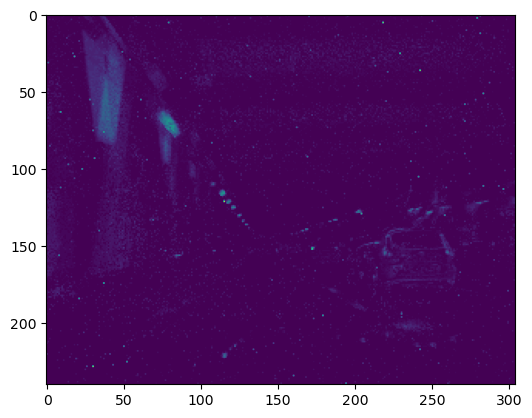

In [33]:
i = 3
# Applying non-max suppression to remove overlapping bounding boxes 
nms_boxes = nms(bboxes[i], iou_threshold=0.5, threshold=0.6) 
# Plotting the image with bounding boxes 
plot_image(np.tanh(np.abs(x[i].permute(1,2,0).detach().cpu())), nms_boxes)

In [67]:
bboxes[0]

[[0.0,
  0.498108834028244,
  0.06248091161251068,
  0.06237531080842018,
  4.27573823928833,
  2.613299608230591],
 [0.0,
  0.4984973669052124,
  0.18749357759952545,
  0.06235823407769203,
  4.373289585113525,
  2.7165865898132324],
 [0.0,
  0.5067539811134338,
  0.31372904777526855,
  0.06294533610343933,
  4.266922950744629,
  2.6419286727905273],
 [1.0,
  0.4986206293106079,
  0.4374956488609314,
  0.06237656623125076,
  4.543410301208496,
  2.650383710861206],
 [0.0,
  0.49996745586395264,
  0.5635036826133728,
  0.06231178715825081,
  4.252213478088379,
  2.621342658996582],
 [1.0,
  0.5030850768089294,
  0.6882725954055786,
  0.062363266944885254,
  4.263902187347412,
  2.660146474838257],
 [1.0,
  0.4983080327510834,
  0.8124348521232605,
  0.06418430060148239,
  4.429834365844727,
  2.6145529747009277],
 [0.0,
  0.503704845905304,
  0.9390972256660461,
  0.06247816979885101,
  4.253850936889648,
  2.648885726928711],
 [1.0,
  0.497906893491745,
  0.06373490393161774,
  0.1893